# Artificial Intelligence Course - Fall 1402
## Computer Assignment #3 - HMMs
### provided by: Mohamad Amin Yousefi
#### SID: 810100236

This notebook presents a Hidden Markov Model approach to music genre classification. We are given a dataset containing 4 genres of musics which each genre has 100 samples, each approximately 30 seconds in length, by removing the initial empty part of each file.

In [62]:
import numpy as np
import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from hmmlearn import hmm
from python_speech_features import mfcc as Mfcc
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.stats import multivariate_normal
import sklearn.metrics as sk_metrics

In [63]:
DS_train=dict()
min_audio_frame = 2985
metrics = ["accuracy", "precision", "recall", "f1_score"]
average_methods=["macro", "micro", "weighted"]
audio_genres = ["blues","metal","hiphop","pop"]
genres_folder_path = [f".\data\{audio_genres[0]}\*.wav", f".\data\{audio_genres[1]}\*.wav", f".\data\{audio_genres[2]}\*.wav", f".\data\{audio_genres[3]}\*.wav"]

## Part1: Preprocess

### Question 1:
Fixed-length inputs are a prerequisite for numerous machine learning models. Ensuring uniform sample length establishes a standardized input shape crucial for the employed model's consistency.
During model training, batch processing emerges as a prevalent and efficient technique. The uniform length of samples streamlines batch processing, optimizing the overall training procedure.
The simplicity of preprocessing tasks is significantly enhanced when dealing with samples of identical length. The absence of variable-length sequences eliminates the need for intricate considerations.
Given that Mel-frequency cepstral coefficients (MFCCs) are commonly computed over audio segments with fixed lengths, maintaining uniform input lengths facilitates the seamless comparison of extracted features across diverse samples.

### Question 2:
Leveraging overlapping frames in MFCC extraction proves beneficial for capturing temporal changes in the audio signal, mitigating variability, and generating a more fluid representation suitable for various audio analysis tasks.

### Question 3:
The initial MFCCs frequently encapsulate the most salient and crucial features pertaining to the spectral shape and energy distribution of the audio. Consequently, employing fewer frames allows for a reduction in feature dimensionality, proving advantageous for computational efficiency.
Concentrating on the first 12 or 13 MFCCs enables the capture of perceptually significant information while minimizing redundancy. Research indicates that humans exhibit greater sensitivity to lower-order MFCCs, making this focus particularly relevant for comprehensive information extraction.

In [64]:
def calc_mfcc(audio_files):
    mfccs_list = []
    for audio_file in audio_files:
        sampling_rate, audio = wavfile.read(audio_file)
        mfcc = Mfcc(audio, samplerate=sampling_rate, nfft=1024)[:min_audio_frame, :]
        mfccs_list.append(mfcc)
    return mfccs_list

def mfcc_heatmap(title, mfccs_array):
    plt.matshow(mfccs_array[0].T, cmap='Spectral',origin='lower', aspect='auto')
    plt.title(f"{title} genre Mfcc heatmap")
    plt.ylabel('Coefficients')
    plt.xlabel('Time')
    plt.colorbar()
    plt.show()

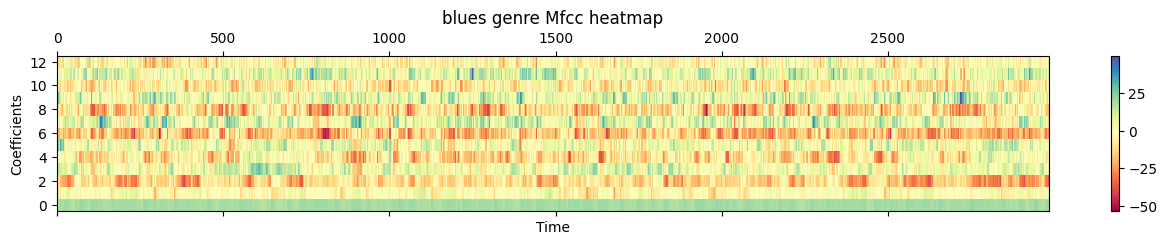

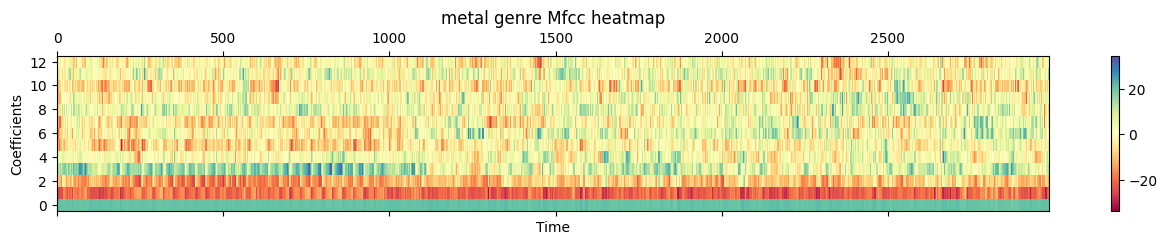

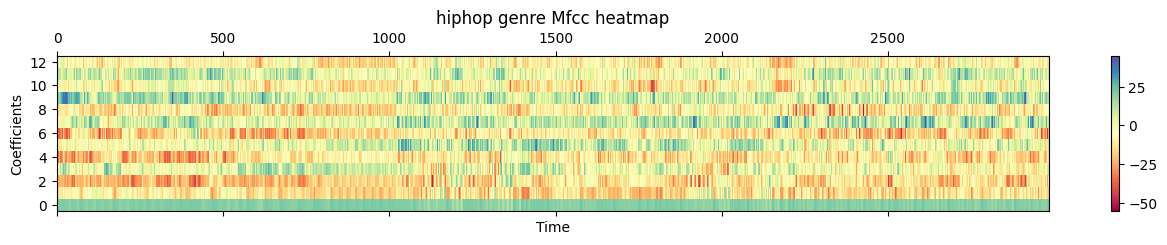

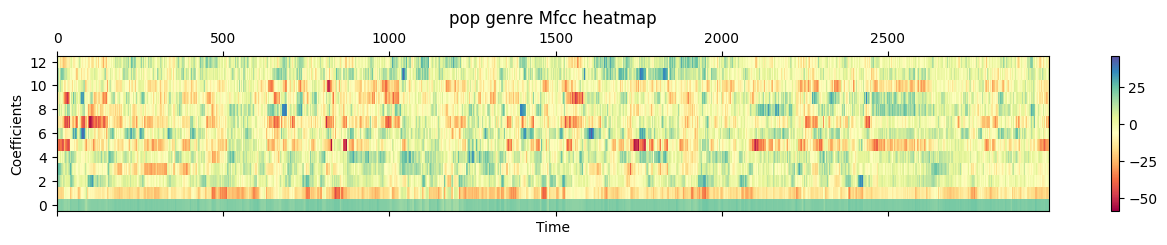

In [65]:
total_mfccs = []
total_genres = []
for i in range(len(audio_genres)):
    whole_genre = glob.glob(genres_folder_path[i])
    mfccs_array = calc_mfcc(whole_genre)
    total_mfccs.append(mfccs_array)
    total_genres.append([i] * len(mfccs_array))
    mfcc_heatmap(audio_genres[i], mfccs_array)

## Part2: Implementing HMM using library

### Question 1:
- states: hidden states which are hidden in model and we are trying to use observations to reach states. in this problem, states are audio categories(```blues``` ,```metal``` ,```hiphop```, ```pop```) which are unkown to us.
- observation: observed states or experiences which are known to us. in this problem, observations are features of audios obtained by MFCC.

### Question 2:
A first-order HMM, also known as a first-order Markov model, assumes that the probability of transitioning to any particular state depends only on the current state and not on the sequence of states that preceded it. 
In contrast, a higher-order HMM considers dependencies on the current and one or more previous states when determining the transition probabilities. The higher-order models can capture more complex dependencies in the sequence of states.

### Question 3:
Hidden Markov Models are probabilistic models that are particularly well-suited for analyzing and modeling phenomena characterized by sequential data and underlying hidden states. They are useful when working with sequential data like a series of events or a time series. They are good at capturing the relationships between these events and can help us understand how things change over time.
#### some examples of HMM's application:
```Natural Language Processing:```  HMMs can model the sequential nature of language and capture the dependencies between different words. Words in a sentence are treated as observable emissions, and underlying grammatical structures are represented by hidden states.

```Speech Recognition:``` HMMs are widely employed in speech recognition systems. The speech signal is modeled as a sequence of hidden states, and each state emits observable features. HMMs can effectively model the variability in speech patterns and account for the temporal nature of spoken language.

```Bioinformatics:``` They can model biological sequences as sequences of hidden states and capture dependencies between adjacent elements.

### Question 4:
#### pros:
- HMMs are well-suited for modeling sequences of observations where the underlying system can be represented as a sequence of hidden states.
- HMMs can handle missing data by incorporating probabilities for observation emissions.
- HMM parameters (transition probabilities, emission probabilities) can be learned from data using algorithms such as the Expectation-Maximization algorithm.
- HMMs provide a probabilistic framework for modeling uncertainties in the data. 
- HMMs provide a probabilistic framework for modeling uncertainties in the data. This makes them useful in scenarios where there is uncertainty or variability.
#### cons:
- HMMs assume the Markov property, which means that the future state depends only on the current state. This may not hold in all real-world scenarios.
- As the number of hidden states and parameters increases, the model's complexity grows, leading to potential scalability issues, especially when dealing with large datasets.
- HMMs can be sensitive to the choice of initial conditions, and convergence to optimal parameters can be influenced by the quality of the initial estimates.

### Question 5:
I have talked about First-order and Higher-order as two different models of HMM's. There are some oder models as well.<br>
```1.Left-Right: ```
A type of HMM where the states are organized in a left-to-right structure, meaning transitions can only occur from left to right. This structure is commonly used in speech recognition.<br>
```2.Continuous:```
Used when the observations emitted from the hidden states are continuous rather than discrete. This is common in applications like speech and gesture recognition.<br>
```3.Mixture:```
Combines multiple HMMs to form a mixture model. Each component HMM in the mixture represents a different mode of the system, and the model can switch between these modes.<br>
```4.Factorial:```
Introduces a factorial structure in the emission probabilities, allowing dependencies between different elements of the observation vector.

In [66]:
data_test_x = []
data_test_y = []

for i in range(len(audio_genres)):
    x_train, x_test, y_train, y_test = train_test_split(np.array(total_mfccs[i]), np.array(total_genres[i]), test_size=0.2, random_state=42)
    DS_train[audio_genres[i]] = x_train.reshape((x_train.shape[0] * x_train.shape[1], x_train.shape[2]))
    data_test_x.append(list(x_test))
    data_test_y.append(y_test)

data_test_x = np.array(data_test_x)
data_test_x = data_test_x.reshape((data_test_x.shape[0] * data_test_x.shape[1], data_test_x.shape[2], data_test_x.shape[3]))
data_test_y = np.array(data_test_y).flatten()

In [67]:
genre_HMM_models=[]
library_y_predictions=[]
for genre in audio_genres:
    model = hmm.GaussianHMM(n_components=4, covariance_type='diag')
    model.fit(DS_train[genre])
    genre_HMM_models.append(model)

for i in range(data_test_x.shape[0]):
    scores=[]
    for model in genre_HMM_models:
        scores.append(model.score(data_test_x[i,:]))
    label = np.argmax(np.array(scores))
    library_y_predictions.append(label)

In [68]:
def plot_conf_matrix(conf_matrix, class_labels):

    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.YlGn)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xticks(np.arange(len(class_labels)), class_labels)
    plt.yticks(np.arange(len(class_labels)), class_labels)
    for i in range(len(class_labels)):
        for j in range(len(class_labels)):
            plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

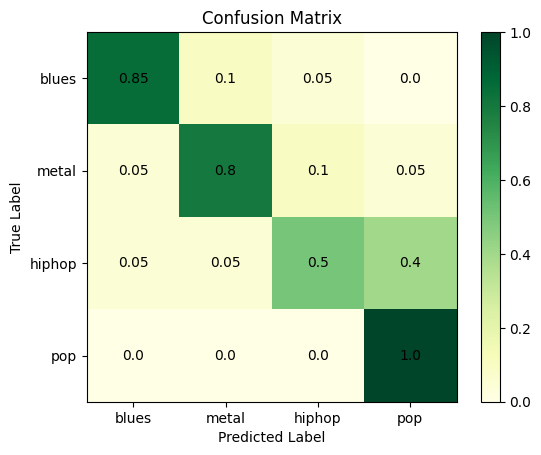

In [69]:
matrix = sk_metrics.confusion_matrix(data_test_y, np.array(library_y_predictions))/20
plot_conf_matrix(matrix, audio_genres)

## Part3: Implementing HMM from scratch

In [70]:
class HMM:
    def __init__(self, num_hidden_states):
        self.num_hidden_states = num_hidden_states
        self.rand_state = np.random.RandomState(1)

        self.initial_prob = self._normalize(self.rand_state.rand(self.num_hidden_states, 1))
        self.transition_matrix = self._stochasticize(self.rand_state.rand(self.num_hidden_states, self.num_hidden_states))

        self.mean = None
        self.covariances = None
        self.num_dimensions = None


    def _forward(self, observation_matrix):
        log_likelihood = 0.
        T = observation_matrix.shape[1]
        alpha = np.zeros(observation_matrix.shape)

        for t in range(T):
            if t == 0:
                alpha[:,0] =  self.initial_prob[:,0] * observation_matrix[:,0]
            else:
                alpha[:,t] = observation_matrix[:,t] * np.matmul(self.transition_matrix.T, alpha[:,t-1])

            alpha_sum = np.sum(alpha[:, t])
            alpha[:, t] /= alpha_sum
            log_likelihood += np.log(alpha_sum)

        return log_likelihood, alpha


    def _backward(self, observation_matrix):
        T = observation_matrix.shape[1]
        beta = np.zeros(observation_matrix.shape)
        beta[:, -1] = np.ones(observation_matrix.shape[0])
        for t in range(T - 1)[::-1]:
            beta[:, t] = np.matmul(self.transition_matrix, (observation_matrix[:,t+1] * beta[:,t+1]))
            beta[:, t] /= np.sum(beta[:, t])
        return beta

    def _state_likelihood(self, obs):
        obs = np.atleast_2d(obs)
        B = np.zeros((self.num_hidden_states, obs.shape[1]))
        for s in range(self.num_hidden_states):
            np.random.seed(self.rand_state.randint(1))
            B[s, :] = multivariate_normal.pdf(obs.T,mean =self.mean[:,s],cov = self.covariances[:,:,s])
        return B

    def _normalize(self, x):
        return (x + (x == 0)) / np.sum(x)

    def _stochasticize(self, x):
        return (x + (x == 0)) / np.sum(x, axis=1)

    def _em_init(self, obs):
        if self.num_dimensions is None:
            self.num_dimensions = obs.shape[0]
        if self.mean is None:
            subset = self.rand_state.choice(np.arange(self.num_dimensions), size=self.num_hidden_states, replace=False)
            self.mean = obs[:, subset]
        if self.covariances is None:
            self.covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
            self.covariances += np.diag(np.diag(np.cov(obs)))[:, :, None]

        return self

    def _em_step(self, obs):
        obs = np.atleast_2d(obs)
        T = obs.shape[1]
        B = self._state_likelihood(obs=obs)
        
        log_likelihood, alpha = self._forward(B)
        beta = self._backward(B)

        xi_sum = np.zeros((self.num_hidden_states, self.num_hidden_states))
        gamma = np.zeros((self.num_hidden_states, T))

        for t in range(T - 1):
            partial_sum = sum(alpha[:,t] * beta[:,t+1] * B[:,t+1]) * self.transition_matrix
            xi_sum += self._normalize(partial_sum)
            partial_g = alpha[:,t] * beta[:,t]
            gamma[:, t] = self._normalize(partial_g)
            
        partial_g = alpha[:,T-1] * beta[:,T-1]
        gamma[:, -1] = self._normalize(partial_g)

        expected_prior = np.reshape(gamma[:, 0],(-1,1))
        expected_transition = self._stochasticize(xi_sum/np.sum(xi_sum,axis=(0,1)))

        expected_covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
        expected_covariances += .01 * np.eye(self.num_dimensions)[:, :, None]

        gamma_state_sum = np.sum(gamma, axis=1)
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)

        expected_mean = np.zeros((self.num_dimensions, self.num_hidden_states))
        for s in range(self.num_hidden_states):
            gamma_obs = obs * gamma[s, :]
            expected_mean[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]

        self.initial_prob = expected_prior
        self.mean = expected_mean
        self.covariances = expected_covariances
        self.transition_matrix = expected_transition

        return log_likelihood

    def train(self, obs, num_iterations=1):
        for i in range(num_iterations):
            self._em_init(obs)
            self._em_step(obs)
        return self

    def score(self, obs):
        B = self._state_likelihood(obs)
        log_likelihood, _ = self._forward(B)
        return log_likelihood


In [71]:
genre_HMM_models = []

for label in audio_genres:
    model = HMM(num_hidden_states=4)
    model.train(DS_train[label].T/np.amax(DS_train[label].T),num_iterations=2)
    genre_HMM_models.append(model)

y_preds_scratch=[]
for i in range(data_test_x.shape[0]):
    scores=[]
    for model in genre_HMM_models:
        scores.append(model.score(data_test_x[i,:].T/np.amax(data_test_x[i,:].T)))
    label = np.argmax(np.array(scores))
    y_preds_scratch.append(label)

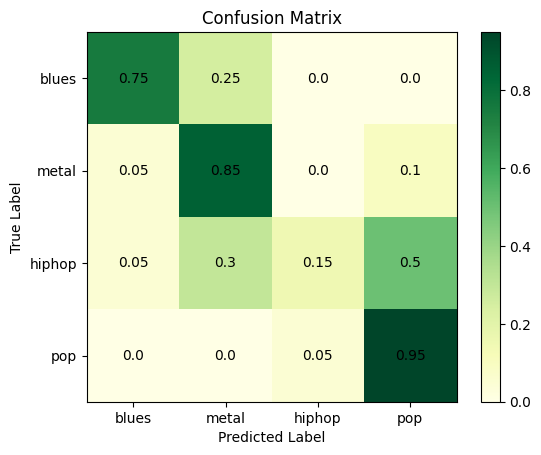

In [72]:
matrix = sk_metrics.confusion_matrix(data_test_y, np.array(y_preds_scratch))/20
plot_conf_matrix(matrix, audio_genres)

In [73]:
def seprate_data(y_preds, y_test, genre):
    seprated_y_test = []
    seprated_y_preds = []
    for i in range(len(y_test)):
        if y_test[i] == genre:
            seprated_y_test.append(1)
        else:
            seprated_y_test.append(0)
        if (y_preds[i] == genre):
            seprated_y_preds.append(1)
        else:
            seprated_y_preds.append(0)
    return seprated_y_test, seprated_y_preds

def calc_metrics(data_test_y, pred_y):
    
    print(f"accuracy of the model is {sk_metrics.accuracy_score(data_test_y, np.array(pred_y)):.2f}")

    print("\nWe calculate metrics for each class:\n")
    for i in range(len(audio_genres)):
        seprated_y_test, seprated_y_preds = seprate_data(pred_y, data_test_y, i)
        print(f"\t{metrics[0]} in audio genre {audio_genres[i]} is {sk_metrics.accuracy_score(np.array(seprated_y_test), np.array(seprated_y_preds)):.2f}")
        print(f"\t{metrics[1]} in audio genre {audio_genres[i]} is {sk_metrics.precision_score(np.array(seprated_y_test), np.array(seprated_y_preds)):.2f}")
        print(f"\t{metrics[2]} in audio genre {audio_genres[i]} is {sk_metrics.recall_score(np.array(seprated_y_test), np.array(seprated_y_preds)):.2f}")
        print(f"\t{metrics[3]} in audio genre {audio_genres[i]} is {sk_metrics.f1_score(np.array(seprated_y_test), np.array(seprated_y_preds)):.2f}\n")

    print("\nWe calculate metrics for each class with different mothods:\n")
    for average_method in average_methods:
        print(f"\tprecision in {average_method} method is {sk_metrics.precision_score(data_test_y, np.array(pred_y), average=average_method):.2f}")
        print(f"\trecall in {average_method} method is {sk_metrics.recall_score(data_test_y, np.array(pred_y), average=average_method):.2f}")
        print(f"\tf1_score in {average_method} method is {sk_metrics.f1_score(data_test_y, np.array(pred_y), average=average_method):.2f}\n")


In [77]:
calc_metrics(data_test_y, library_y_predictions)

accuracy of the model is 0.79

We calculate metrics for each class:

	accuracy in audio genre blues is 0.94
	precision in audio genre blues is 0.89
	recall in audio genre blues is 0.85
	f1_score in audio genre blues is 0.87

	accuracy in audio genre metal is 0.91
	precision in audio genre metal is 0.84
	recall in audio genre metal is 0.80
	f1_score in audio genre metal is 0.82

	accuracy in audio genre hiphop is 0.84
	precision in audio genre hiphop is 0.77
	recall in audio genre hiphop is 0.50
	f1_score in audio genre hiphop is 0.61

	accuracy in audio genre pop is 0.89
	precision in audio genre pop is 0.69
	recall in audio genre pop is 1.00
	f1_score in audio genre pop is 0.82


We calculate metrics for each class with different mothods:

	precision in macro method is 0.80
	recall in macro method is 0.79
	f1_score in macro method is 0.78

	precision in micro method is 0.79
	recall in micro method is 0.79
	f1_score in micro method is 0.79

	precision in weighted method is 0.80
	recall

In [76]:
calc_metrics(data_test_y, y_preds_scratch)

accuracy of the model is 0.68

We calculate metrics for each class:

	accuracy in audio genre blues is 0.91
	precision in audio genre blues is 0.88
	recall in audio genre blues is 0.75
	f1_score in audio genre blues is 0.81

	accuracy in audio genre metal is 0.82
	precision in audio genre metal is 0.61
	recall in audio genre metal is 0.85
	f1_score in audio genre metal is 0.71

	accuracy in audio genre hiphop is 0.78
	precision in audio genre hiphop is 0.75
	recall in audio genre hiphop is 0.15
	f1_score in audio genre hiphop is 0.25

	accuracy in audio genre pop is 0.84
	precision in audio genre pop is 0.61
	recall in audio genre pop is 0.95
	f1_score in audio genre pop is 0.75


We calculate metrics for each class with different mothods:

	precision in macro method is 0.71
	recall in macro method is 0.68
	f1_score in macro method is 0.63

	precision in micro method is 0.68
	recall in micro method is 0.68
	f1_score in micro method is 0.68

	precision in weighted method is 0.71
	recall

### Question 1:
```Accuracy:```<br>
Accuracy is a commonly used metric for evaluating the performance of classification models. It measures the proportion of correctly classified instances among the total number of instances. The formula for accuracy is:
$$\ \text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}} =\frac{\text{True Positive} + \text{True Negative}}{\text{True Positive} + \text{True Negative} + \text{False Positive} + \text{False Negative}} \$$
while accuracy is a simple and easy-to-understand metric, it's important to consider the specific characteristics of your dataset and the goals of your model. Depending on the context, other evaluation metrics such as precision, recall, F1 score, area under the receiver operating characteristic (ROC) curve, or area under the precision-recall curve may be more appropriate for assessing model performance.

```Precision:```<br>
Precision is a metric used in the evaluation of classification models, particularly in the context of binary classification problems. It focuses on the accuracy of the positive predictions made by the model, indicating how many of the instances predicted as positive are truly positive. Precision is defined as:
$$ \text{Precision} = \frac{\text{True Positives}}{\text{True Positives + False Positives}} \$$
precision is a valuable metric when the focus is on minimizing false positives, and it should be considered alongside other metrics to gain a more comprehensive understanding of a model's performance, especially in situations where the consequences of false positives are significant.

```Recall:```<br>
Recall, also known as sensitivity or true positive rate, is a metric used in the evaluation of classification models, particularly in binary classification problems. Recall measures the ability of a model to capture all the relevant instances of a positive class. It is defined as:
$$ \text{Precision} = \frac{\text{True Positives}}{\text{True Positives + False Negatives}} \$$
recall is a crucial metric when the emphasis is on minimizing false negatives, and it should be considered alongside other metrics (such as precision and F1 score) to comprehensively evaluate a model's performance in different aspects.

```F1 Score:```<br>
The F1 score is a metric that combines precision and recall into a single value, providing a balanced measure of a model's performance in binary classification problems. It is especially useful when there is an uneven class distribution or when false positives and false negatives have different consequences. The formula for the F1 score is:
$$ \text{F1 score} = \frac{2 \times (\text{Precision} \times \text{Recall})}{\text{Precision} + \text{Recall}} $$
the F1 score is a consolidated metric that balances precision and recall, offering a single value that summarizes a model's performance in binary classification tasks. It provides a comprehensive evaluation, especially in situations where false positives and false negatives have different implications.


### Question 2:
```Recall (Sensitivity or True Positive Rate):```<br>
Recall measures the ability of a classification model to capture all the relevant instances, specifically the proportion of actual positive instances (true positives) that were correctly identified by the model.
Recall is calculated as the ratio of true positives to the sum of true positives and false negatives.
A high recall indicates that the model is effective at capturing a large portion of the actual positive instances, minimizing false negatives.<br>

```Precision (Positive Predictive Value):```<br>
Precision assesses the accuracy of the model's positive predictions, indicating the ratio of true positives to the sum of true positives and false positives.
It focuses on the precision of the model's positive predictions, helping to identify how many of the predicted positive instances are actually correct.
High precision indicates that the model is conservative in labeling instances as positive, minimizing false positives.

```High Recall```:
consider scenario which we have 100 product which only 10 of them is broke. if we train a model which always returns "working", it's answering correct at 90% of times.

```High Precision```:
on the other hand, if we have the same condition, if our model always return "broke", it's precision is 100%.



### Question 3:
The F1 score uses the harmonic mean, which is less sensitive to extreme values, making it suitable for skewed distributions or datasets with rates and ratios. This helps counter the impact of imbalanced data distributions in F1 score calculations.

### Question 4:
```Macro```: Precision and Recall are determined for individual classes, and their averages hold equal importance in the final calculation. This ensures an equal impact from each class on the overall value. 

```Micro```: Commencing with the total count of true positives, false positives, and false negatives across all classes, Precision and Recall are calculated. The overall Precision and Recall values are then determined based on these aggregated counts, with the micro-average method assigning equal weight to each instance.

```Weighted```:  Weighted-averaging allocates a weight to each class according to its prevalence in the dataset. Classes with a higher number of instances exert a more substantial influence on the ultimate average.
This approach proves beneficial in scenarios where there exists an imbalance among classes, as it accords greater significance to the metrics of classes with a larger presence. It furnishes a well-rounded performance assessment that takes into account both the collective and class-specific contributions.


### Question 6:
in part in which we used libraries, we could see a better result which is not extremly better than implemention from scratch but in average, it's more reliable. the difference is obvious in hiphop genre. we can improve second implementation by increasing the number of iterations.

### Question 7:
The library model, equipped with the flexibility to employ various Hidden Markov Model (HMM) structures and engage in hyperparameter optimization, stands out for its efficiency in executing intricate algorithms. The critical aspect lies in how it translates observations into the B matrix. Contrasting it with our model, notable differences include the use of a convergence monitor in the hmmlearn model, as opposed to hard-coded iterations in ours. Due to efficiency constraints, our model cannot use a higher number of iterations for better training. Additionally, the library model may leverage hyperparameter optimization and different data preprocessing methods to enhance its learning capabilities.
